# SpacePy Tutorial -- Cusp Energetic Particles
This tutorial reproduces key figures from "Association of cusp energetic ions with geomagnetic storms and substorms" (Niehof et al, 2012; [doi:10.5194/angeo-30-1633-2012](https://doi.org/10.5194/angeo-30-1633-2012)).

It illustrates several functions in SpacePy and the scientific Python ecosystem:

  - Import of IDL data [scipy.io](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.readsav.html#scipy.io.readsav)
  - Omni and related solar wind data [spacepy.omni](https://spacepy.github.io/omni.html)
  - Pressure-corrected Dst* [spacepy.empiricals.getDststar](https://spacepy.github.io/autosummary/spacepy.empiricals.getDststar.html#spacepy.empiricals.getDststar)
  - Workflow support for by-hand event identification [spacepy.plot.utils.EventClicker](https://spacepy.github.io/autosummary/spacepy.plot.utils.EventClicker.html#spacepy.plot.utils.EventClicker)
  - Superposed epoch analysis [spacepy.seapy](https://spacepy.github.io/seapy.html)
  - Point-processes [spacepy.poppy](https://spacepy.github.io/poppy.html)

- https://github.com/heliophysicsPy/summer-school-24/blob/main/spacepy-tutorial/SpacePy%20-%20MMS%20Ephemeris.md

## Setup
Follow these instructions if you are running this notebook on your own, outside of the summer school environment. If you are in the summer school, skip this section.

The first thing we need to do is install SpacePy. If SpacePy is already installed, you can remove that line. We then update the OMNI solar wind database and leapsecond database which we will use later, using using [spacepy.toolbox.update()](https://spacepy.github.io/autosummary/spacepy.toolbox.html#spacepy.toolbox.update).

```python
# Update geomagnetic index and leapsecond data
import spacepy.toolbox
# spacepy.toolbox.update(all=True)

spacepy.toolbox.update(omni2=True)
spacepy.toolbox.update(leapsecs=True)
```

> In the meantime, Steve generated up-to-date files and I've processed them into the final parsed SpacePy database. That can be downloaded [here](https://spp-isois.sr.unh.edu/data_public/omni/omnidata.h5). Place that .h5 file in the data directory inside the [Spacepy DOT_FLN directory](https://spacepy.github.io/configuration.html).

- https://github.com/spacepy/spacepy/issues/731

Download the [sample data for this notebook](https://doi.org/10.5281/zenodo.10904473). Unzip it and update the `tutorial_data` variable in the cell below, then run that cell. It will also download the [high resolution OMNI](https://omniweb.gsfc.nasa.gov/) dataset.

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10904473.svg)](https://doi.org/10.5281/zenodo.10904473)

In [ ]:
import spacepy.toolbox
import os.path
# You will need to update this line to point to the directory where you put the tutorial data.
# This directory should contain hr_dst, savesets, etc.
tutorial_data = os.path.expanduser('./spacepy_tutorial')

# Download high-res omni
hro_base = os.path.join(tutorial_data, 'hro')
spacepy.toolbox._crawl_yearly('https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/',
                              r'omni_hro_5min_(199\d|200[012])[01]\d01_v01.cdf', hro_base, startyear=1996)

Finding files to download ...
Listing files ...100%
Retrieving files ...
Download Progress ...100%


['omni_hro_5min_19960101_v01.cdf',
 'omni_hro_5min_19960201_v01.cdf',
 'omni_hro_5min_19960301_v01.cdf',
 'omni_hro_5min_19960401_v01.cdf',
 'omni_hro_5min_19960501_v01.cdf',
 'omni_hro_5min_19960601_v01.cdf',
 'omni_hro_5min_19960701_v01.cdf',
 'omni_hro_5min_19960801_v01.cdf',
 'omni_hro_5min_19960901_v01.cdf',
 'omni_hro_5min_19961001_v01.cdf',
 'omni_hro_5min_19961101_v01.cdf',
 'omni_hro_5min_19961201_v01.cdf',
 'omni_hro_5min_19970101_v01.cdf',
 'omni_hro_5min_19970201_v01.cdf',
 'omni_hro_5min_19970301_v01.cdf',
 'omni_hro_5min_19970401_v01.cdf',
 'omni_hro_5min_19970501_v01.cdf',
 'omni_hro_5min_19970601_v01.cdf',
 'omni_hro_5min_19970701_v01.cdf',
 'omni_hro_5min_19970801_v01.cdf',
 'omni_hro_5min_19970901_v01.cdf',
 'omni_hro_5min_19971001_v01.cdf',
 'omni_hro_5min_19971101_v01.cdf',
 'omni_hro_5min_19971201_v01.cdf',
 'omni_hro_5min_19980101_v01.cdf',
 'omni_hro_5min_19980201_v01.cdf',
 'omni_hro_5min_19980301_v01.cdf',
 'omni_hro_5min_19980401_v01.cdf',
 'omni_hro_5min_1998

## Background
This study relates to energetic ions observed in the Earth's magnetospheric cusp and the connection to the tail region. The magnetic field geometry is critical to the physics involved. For those unfamiliar with magnetospheric physics, we illustrate them via SpacePy's support for field models and their visualization--using a sledghammer to kill a flea.

### Getting the model field
The [getBfield](https://spacepy.github.io/autosummary/spacepy.irbempy.get_Bfield.html#spacepy.irbempy.get_Bfield) function returns a model magnetic field at a given location and time. The positions are given as [Coords](https://spacepy.github.io/autosummary/spacepy.coordinates.Coords.html#spacepy.coordinates.Coords) objects and the times as [Ticktock](https://spacepy.github.io/autosummary/spacepy.time.Ticktock.html#spacepy.time.Ticktock).

`Coords` operates on a 2D array, where the second dimension is the (x, y, z) components. Ultimately we would like to have a 2D grid of the field for a given (x, z) in the y=0 plane.

Most external field models depend on solar wind conditions, which are provided by the [omni](https://spacepy.github.io/omni.html) module.

`getBfield` returns a field in GEO coordinates, so the [convert](https://spacepy.github.io/autosummary/spacepy.coordinates.Coords.html#spacepy.coordinates.Coords.convert) method is used to also express the field itself in GSE.

#### Things to try
Show the results in different coordinate systems, or look at different magnetic field models. Edit this cell, re-run it, and then run the cells after to see the results.


In [ ]:
import datetime

import numpy
import spacepy.coordinates
import spacepy.irbempy
import spacepy.time

# Coordinates in GSE Re, expressed as an XZ grid (will assume Y=0, noon-midnight plane)
x = numpy.arange(-15, 10.1, 0.1)
z = numpy.arange(-8, 8.1, 0.1)
# Repeat so that every X component is repeated across every Z, and throw in Y=0
_ = numpy.meshgrid(x, 0, z)
# Combine into a single array
_ = numpy.stack(_, axis=-1)
# And flatten out to an array of one (x, y, z) for each position
location = _.reshape(-1, 3)
# Distance from Earth center, useful later
r = numpy.sqrt(numpy.sum(location ** 2, axis=1))
# TRY: SM or GSM coordinates
system = 'GSE'
# Define a full coordinate object
location = spacepy.coordinates.Coords(location, system, 'car', use_irbem=False)
# Use the same time for all locations
ticks = spacepy.time.Ticktock([datetime.datetime(2000, 4, 6)] * len(location))
# Calculate magnetic field across the domain at this time
# TRY: Other options: OPDYN, T89, T05
b = spacepy.irbempy.get_Bfield(ticks, location, extMag='T96')
b_mag, b_vec = b['Blocal'], b['Bvec']
# Magnetic field is given in GEO; since this is a simple rotation,
# can directly convert
c = spacepy.coordinates.Coords(b_vec, 'GEO', 'car', ticks=ticks, use_irbem=False)
b_vec = c.convert(system, 'car').data  # Revert to simple array
# Magnetic field model is not valid inside the Earth, but keep values
# near the surface
b_vec[r < .9, :] = numpy.nan
# Return to a grid representation
b_vec = b_vec.reshape(len(x), len(z), 3)
b_mag = b_mag.reshape(len(x), len(z))

### Plotting field magnitude and direction
[pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) plots values as colors on a grid. In this case we use it to plot the magnetic field magnitude on a grid of (x, z). By specifying [LogNorm](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LogNorm.html) the colorbar is treated as logarithmic.

So we can also see the field direction, we convert the vector field to unit vectors. In addition to the aggregate operation (dividing all of the field vectors by all magnitudes at once) Numpy's [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) rules allow us to divide every component (x, y, z) by the magnitude without having to repeat the magnitude.

These unit vectors are plotted with [quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html?highlight=quiver#matplotlib.axes.Axes.quiver), i.e., a collection of arrows. The slice notation `[::4]` is used to select every fourth value (in x and z) so there is room for the arrows.

The spatial grid is treated as `(x, z)`, with z plotted on the y axis. matplotlib treats these as arrays with the first index as the row, and rows plotted on y...thus the frequent [transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html).

#### Things to try
Change the normalization (range or log/linear) for the color plot; change the density of arrows.


<matplotlib.quiver.Quiver>

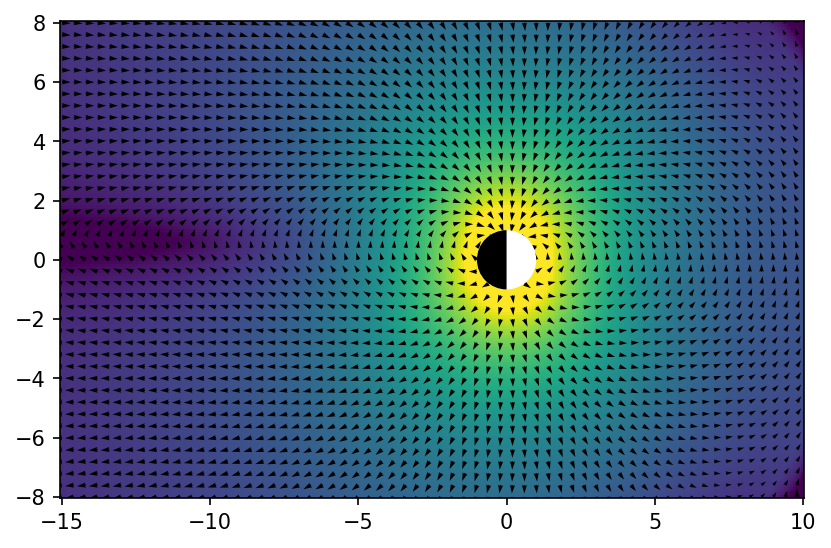

In [ ]:
import matplotlib.colors
import matplotlib.pyplot
import spacepy.pybats

fig = matplotlib.pyplot.figure(dpi=150)
ax = fig.add_subplot(111)
# TRY: Remove the normalization to have the default linear scale, or change min/max values
ax.pcolormesh(x, z, b_mag.transpose(), norm=matplotlib.colors.LogNorm(vmin=10, vmax=1e4))
ax.set_aspect('equal')  # Make circles circular
spacepy.pybats.add_planet(ax)
# Adds another axis (of size 1) to the magnitude, so all components are divided by same magnitude.
b_hat = b_vec / b_mag[..., None]
# TRY: Change from every 4th point to more or fewer
do_every = 4
ax.quiver(x[::do_every], z[::do_every], b_hat[::do_every, ::do_every, 0].transpose(),
          b_hat[::do_every, ::do_every, 2].transpose(), units='x')

### Field lines
Although the arrow field gives an idea of the field geometry, it's much easier to see the global connectivity by tracing out, and then plotting, the field lines. We use the `trace2d` functionality of [PyBats](https://spacepy.github.io/pybats.html); this simple function underlies the stream tracing support in [Stream](https://spacepy.github.io/autosummary/spacepy.pybats.bats.Stream.html#spacepy.pybats.bats.Stream). Higher-level support for other applications is in design.

The field line trace starts at fixed latitudes, tracing out along the field line from the south pole and out against the field line from the north pole. (This tracing is performed in GSE latitude, not SM, so the hemispheres are not conjugate.) The trace stops when it hits the `nan` in the field, or the edges. Normally the trace is allowed to extend slightly beyond the domain but this sometimes causes numerical issues which are [under investigation](https://github.com/spacepy/spacepy/issues/607), so the trace is explicitly cut off.

#### Things to try
Change the set of latitudes used (e.g. every 15 degrees).

Try looping over starting X explicitly with starting Z fixed at 0 (equatorial plane); note the direction of the trace.

Change the step size.

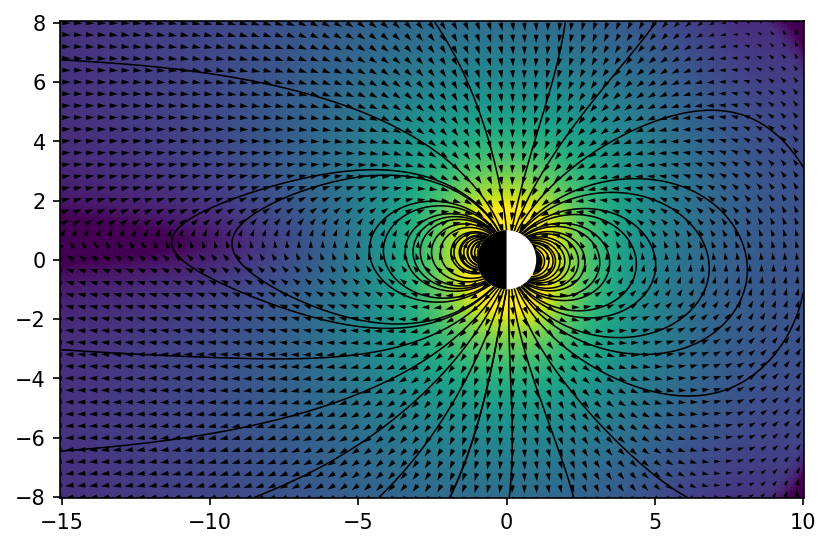

In [ ]:
import spacepy.pybats.trace2d

# TRY: changing latitude range
for lat in numpy.arange(-180, 185, 5):
    # Tracing antiparallel to field from North pole, parallel from South
    direction = 2 * (abs(lat) > 90) - 1
    l = numpy.radians(lat)
    # TRY: Define a range of starting X and start Z from zero, will also need to define direction
    startx = numpy.sin(l)
    startz = numpy.cos(l)
    # TRY: increasing or decreasing step size (ds)
    tracex, tracez = spacepy.pybats.trace2d.trace2d_rk4(
        b_vec[..., 0].transpose() * direction,
        b_vec[..., 2].transpose() * direction,
        startx, startz, x, z, ds=0.1)
    # Find places where hit edge of domain
    ranged_out = numpy.nonzero((tracex < min(x)) | (tracex > max(x)) | (tracez > max(z)) | (tracez < min(z)))[0]
    if len(ranged_out):  # And cut the field trace beyond that point
        tracex = tracex[:ranged_out[0]]
        tracez = tracez[:ranged_out[0]]
    ax.plot(tracex, tracez, color='k', marker='', lw=0.75)
fig

### Magnetopause
It's useful to have the magnetopause location to ensure the domain presented is one where the field model is valid.

The [getMagnetopause](https://spacepy.github.io/autosummary/spacepy.empiricals.getMagnetopause.html#spacepy.empiricals.getMagnetopause) function returns a list of magnetopause locations for a particular time. As with [getBfield](https://spacepy.github.io/autosummary/spacepy.irbempy.get_Bfield.html#spacepy.irbempy.get_Bfield), solar wind conditions are taken from the [omni](https://spacepy.github.io/omni.html) module.

The model used is from [Shue et al (1997)](https://doi.org/10.1029/97JA00196).

We take advantage of the rotational symmetry of the Shue model to plot the magnetopause in the XZ plane. For more involved calculations, the standoff distance and flaring parameters are also available.

#### Things to try
Plot the plasmapause location using [getPlasmaPause](https://spacepy.github.io/autosummary/spacepy.empiricals.getPlasmaPause.html#spacepy.empiricals.getPlasmaPause). Given the XZ slice, this really only makes sense as one location for 00MLT and one for 12MLT

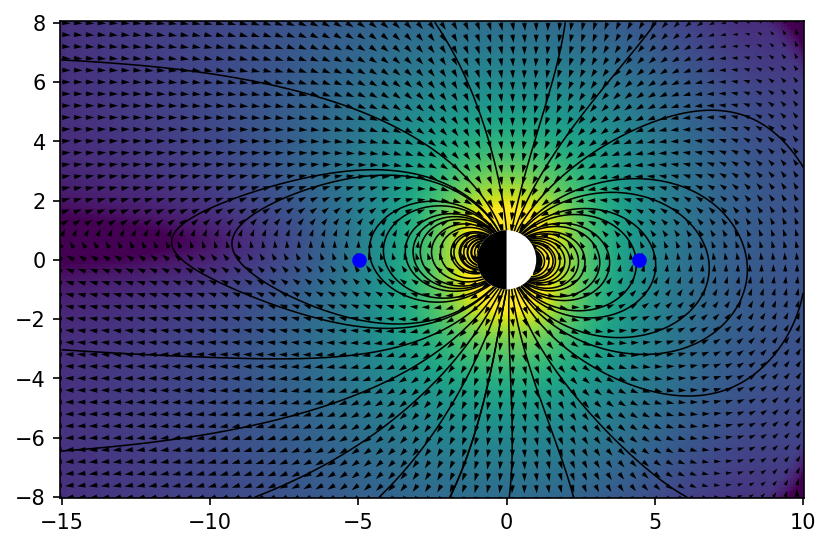

In [ ]:
import spacepy.empiricals

tt = spacepy.time.Ticktock(datetime.datetime(2000, 4, 6))
midnight = spacepy.empiricals.getPlasmaPause(tt, LT=0) * -1  # this is PP distance, midnight is negative X
noon = spacepy.empiricals.getPlasmaPause(tt, LT=12)
ax.plot([midnight, noon], [0,0] , color='b', marker='o', lw=0)
fig

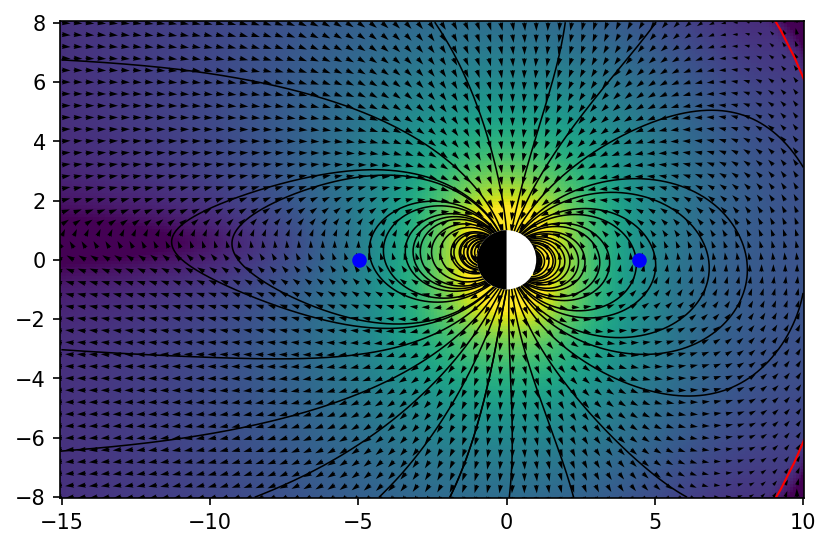

In [ ]:
# Provided in GSE directly
mp_loc = spacepy.empiricals.getMagnetopause(spacepy.time.Ticktock(datetime.datetime(2000, 4, 6)))
ax.autoscale(enable=False)  # Much of the MP is outside of domain, so do not change range of plot
# Taking advantage of the fact that the Shue model is rotationally symmetric, treat the
# Y component of the mpause location as the Z component
ax.plot(mp_loc[0, :, 0], mp_loc[0, :, 1], color='r', marker='', lw=1)
fig

### Labels
Certain features are reasonably visible here: the compression of the field on the dayside, the stretched nature of the tail, and the cusps where more direct solar wind entry is possible. But labeling these features would help them stand out. Many [annotation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html) options are available.

#### Things to try
Change the color of the annotation box.

Put the annotation text in a different place with an arrow pointing to it.

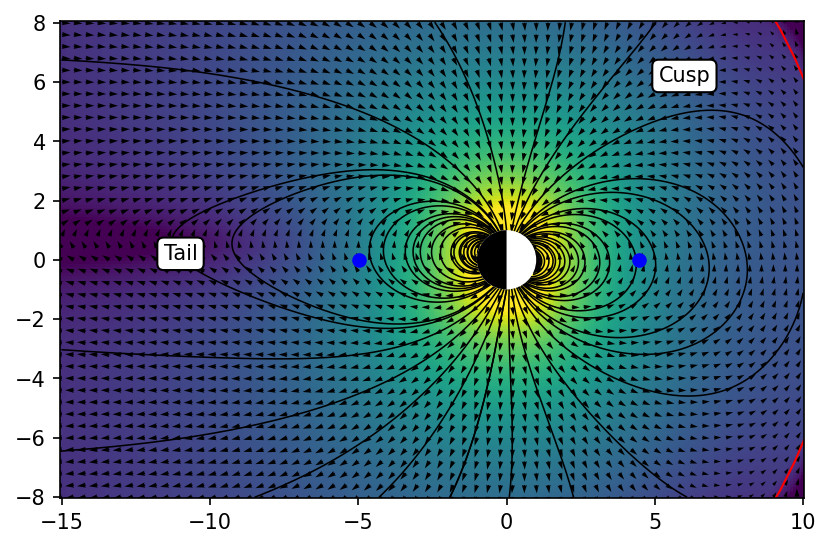

In [ ]:
ax.annotate('Tail', xy=(-11, 0), ha='center', bbox=dict(boxstyle="round", fc='w', ec='k'))
# TRY: Change color with ec, location with xy
ax.annotate('Cusp', xy=(6, 6), ha='center', bbox=dict(boxstyle="round", fc='w', ec='k'))
fig

### Cleanup
Although this has fine output, temporary data arrays are left hanging around. This is a good example of why not to do everything as global variables, as local variables are automatically garbage collected when a function ends. Globals aren't cleaned up until Python exits. 

We'll do cleanup of temporaries throughout the rest of this notebook.

Note that, for example, the `tracex` and `tracez` variables are continually redefined when looping over field lines--each instance is automatically garbage collected when redefined, so there's no need to explicitly delete them.

In [ ]:
del b_vec, b_hat, b_mag, x, z, tracex, tracez

### Science question
This figure provides context for the science question: what are the potential sources and effects of energetic particles observed in the cusp (Cusp Energetic Particles, CEPs), particularly in the deep magnetic depressions associated with the entry of solar wind plasma? Three mechanisms were proposed:

 1. Local acceleration of ions in the cusp, potentially resulting in escape and contribution to ring current populations.
 2. Acceleration of ions in the tail during substorm dipolarizations followed by drift to the dayside.
 3. Acceleration of solar wind ions at the quasi-parallel bow shock.

To test these mechanisms, particularly the first 2, [Niehof et al., (2012)](https://doi.org/10.5194/angeo-30-1633-2012) used a list of cusp crossings and associated energetic particle observations from an earlier study ([Niehof et al., 2010](https://doi.org/10.1029/2009JA014827)).

## Preparing data sets

### Cusp-crossing data
The cusp pass data from the Polar spacecraft in Niehof et al. (2010) was calculated in IDL and saved as an IDL saveset. This provides a good example of moving from IDL to Python. An IDL saveset can easily be read into a Python dictionary with [scipy.io](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.readsav.html#scipy.io.readsav). This saveset has been included in the `tutorial_data` directory.

The data were saved as a series of timestamps (as year, month, day, and minute of day) and conditional arrays for whether Polar was in the cusp or observed energetic particles. Most of the analysis was done using times as seconds since 1996-1-1. This isn't ideal--it's better to stick with a standard representation such as TAI throughout, but at least it is fairly easy to do conversions, so this tutorial can demonstrate the conversions.

This illustrates two different ways to deal with applying a function across elements of multiple numpy arrays: one is to use a list comprehension, and one is to use [vectorize](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html#numpy.vectorize), which will call the function once for each element of the inputs and return an array. `vectorize` does not parallelize, but it's still usually faster than a for loop in Python (it does much of the looping in C).

#### Things to try
Convert the times directly to seconds since 1996 with a single vectorized function, instead of in two steps.

In [ ]:
import os.path
import scipy.io

po_data = scipy.io.readsav(os.path.join(tutorial_data, 'savesets', 'all_passes.idl'))
# Whether in cusp/not, or energetic particles present/not, was saved as 0/1
po_cusp = numpy.require(po_data['cusp'], dtype=bool)
po_cep = numpy.require(po_data['cep'], dtype=bool)
# Times are stored as year, month, day, and minutes since start of day
po_times = numpy.array([
    datetime.datetime(po_data['yyyy'][i], po_data['mm'][i], po_data['dd'][i])
    + datetime.timedelta(minutes=int(po_data['minute'][i]))
    for i in range(len(po_data['yyyy']))])
# To simplify math everything was done as total seconds since 1996-1-1
to_seconds = numpy.vectorize(lambda dt: (dt - datetime.datetime(1996, 1, 1)).total_seconds())
po_times = to_seconds(po_times)

In [ ]:
po_times

array([8.0196600e+06, 8.0197200e+06, 8.0197800e+06, ..., 1.9710354e+08,
       1.9710360e+08, 1.9710366e+08])

In [ ]:
to_seconds_alt = numpy.vectorize(lambda y, m, d, minute: (datetime.datetime(y, m, d)
    - datetime.datetime(1996, 1, 1)).total_seconds() + minute * 60)
po_seconds = to_seconds_alt(po_data['yyyy'], po_data['mm'], po_data['dd'], po_data['minute'])

In [ ]:
po_seconds

array([8.0196600e+06, 8.0197200e+06, 8.0197800e+06, ..., 1.9710354e+08,
       1.9710360e+08, 1.9710366e+08])

In [ ]:
numpy.allclose(po_times, po_seconds)

True

Because of the analysis approach we'll be taking, our times and conditions need to be converted to simple sequences of times: one array of times when Polar was in the cusp, and one of the subset when it was in the cusp and observing energetic particle data.

This is simple with numpy's [boolean indexing](https://numpy.org/doc/stable/user/basics.indexing.html#boolean-array-indexing): indexing an array with a boolean array of the same size returns the values where the index array is `True`.

When writing this paper, these data sets were not built up over a single session. Intermediate steps were saved as [pickles](https://docs.python.org/3/library/pickle.html) using [savepickle](https://spacepy.github.io/autosummary/spacepy.toolbox.savepickle.html#spacepy.toolbox.savepickle). Pickles are very convenient but not necessarily portable. Spacepy's [toHDF5](https://spacepy.github.io/autosummary/spacepy.datamodel.toHDF5.html#spacepy.datamodel.toHDF5) method supports saving in the standard HDF5 format.

#### Things to try
Saving and loading some of the data with ``pickle`` or ``toHDF5`` (which requires placing data into SpacePy's datamodel).

In [ ]:
# Simple array of times, as seconds, when Polar was in the cusp, and observed CEPs
cusp_times = po_times[po_cusp]
cep_times = po_times[po_cep]
del po_data, po_times

### Geomagnetic storms
Intensifications of the ring current are associated with changes in the magnetic field measured at Earth's surface, known as geomagnetic storms (one of the earliest phenomena known to space physics). Thus, if CEPs are a ring current driver, we are interested in any potential association with storms.

The canonical measure of the surface field, taking out effects of location and instrument, is known as Dst. This is calculated on an hourly cadence by the World Data Center in Kyoto. [Gannon and Love (2011)](https://doi.org/10.1016/j.jastp.2010.02.013) extended this approach to provide a comparable one-minute index, allowing for more precise identification of storm onset and minima. A CDF conversion of this dataset is provided with this tutorial data.

[concatCDF](https://spacepy.github.io/autosummary/spacepy.pycdf.concatCDF.html#spacepy.pycdf.concatCDF) provides an easy way to read the same data from a series of CDFs. Two points of detail:

  * The CDFs are opened in a list comprehension, and automatically closed when it goes out of scope.
  * The file listings are explicitly sorted to ensure they are in order. See [Neupane et al. (2019)](https://doi.org/10.1021/acs.orglett.9b03216).

In [ ]:
import glob
import spacepy.pycdf

files = sorted(glob.glob(os.path.join(tutorial_data, 'hr_dst', 'ngp_dst_k0*_v00.cdf')))
dstdata = spacepy.pycdf.concatCDF([spacepy.pycdf.CDF(f) for f in files],
                           ['Dst', 'Epoch'])
dst_times, dst = dstdata['Epoch'], dstdata['Dst']
del dstdata

A quick plot of a few weeks' data shows a moderate storm.

[<matplotlib.lines.Line2D>]

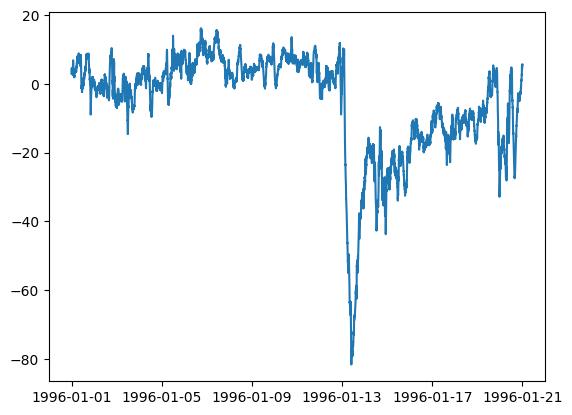

In [ ]:
matplotlib.pyplot.plot(dst_times[:28800], dst[:28800])

In addition to ring current effects, Dst can be affected by magnetosphere compression due to changes in solar wind dynamic pressure. This can obscure the details of storm onset, so a pressure-corrected Dst* index is often used. [getDststar](https://spacepy.github.io/autosummary/spacepy.empiricals.getDststar.html#spacepy.empiricals.getDststar) will return Dst* for given times directly from the hourly OMNI database; however, in this case we are using a one-minute Dst, so wish to use a higher resolution pressure correction. `getDststar` also applies correction from inputs of uncorrected Dst and solar wind dynamic pressure; we obtain the latter from the 5 minute high resolution OMNI dataset.

[numpy.interp](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) will nicely interpolate for us, but it has a few limitations: it won't interpolate across fill, and it doesn't handle datetimes. So we use [Ticktock](https://spacepy.github.io/autosummary/spacepy.time.Ticktock.html#spacepy.time.Ticktock) to convert to TAI.

#### Things to try
Interpolate with a different time representation (e.g. MJD).

Interpolate using [date2num](https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.date2num). This can be useful for quick throwaways, but provides less flexibility.

```python
import matplotlib.dates
pdyn = numpy.interp(matplotlib.dates.date2num(dst_times),
                    matplotlib.dates.date2num(hrodata['Epoch'][hrogood]),
                    hrodata['Pressure'][hrogood])
```

In [ ]:
# This pattern should be familiar from reading the USGS Dst above
hro_files = sorted(glob.glob(os.path.join(tutorial_data, 'hro', 'omni_hro_5min_*01_v01.cdf')))
hrodata = spacepy.pycdf.concatCDF([spacepy.pycdf.CDF(f) for f in hro_files], ['Pressure', 'Epoch'])
# Fill is 99.99 for this data set
hrogood = hrodata['Pressure'] < 50.
# TRY: interpolate using a different timebase, e.g. MJD
pdyn = numpy.interp(spacepy.time.Ticktock(dst_times).TAI,
                    spacepy.time.Ticktock(hrodata['Epoch'][hrogood]).TAI,
                    hrodata['Pressure'][hrogood])
dst_star = spacepy.empiricals.getDststar({'Pdyn': pdyn, 'Dst': dst}, model='OBrien')
del hrodata, pdyn, hrogood

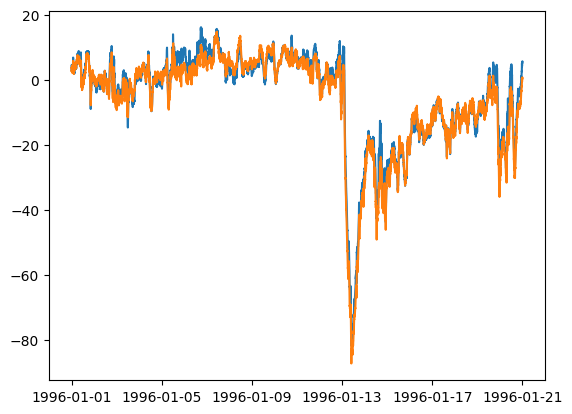

In [ ]:
# View original and corrected Dst
matplotlib.pyplot.plot(dst_times[:28800], dst[:28800])
matplotlib.pyplot.plot(dst_times[:28800], dst_star[:28800]);
# TRY: show the difference

We won't go into the details of storm identification from Dst; we used an existing list of approximate storm minima (<-30nT) during this time as candidates, and identified onset times by eye (independently by two different people, reconciled after.) The onset times are provided in a pickle and [loadpickle](https://spacepy.github.io/autosummary/spacepy.toolbox.loadpickle.html#spacepy.toolbox.loadpickle) provides a convenient function for loading (including compression support).

The SpacePy [EventClicker](https://spacepy.github.io/autosummary/spacepy.plot.utils.EventClicker.html#spacepy.plot.utils.EventClicker) resulted from this work and is very useful for semi-automated feature identification.

Our next plot is the first one that actually went in the paper, so we're going to prompt matplotlib to [render the labels in LaTeX](https://matplotlib.org/stable/tutorials/text/usetex.html). This means the ability to use LaTeX formatting (like superscripts and subscripts), but also that the text in the plot matches that in the manuscript (if the manuscript is in LaTeX and figures are in EPS). Obviously this requires LaTex (and [particular packages for unicode fonts](https://github.com/matplotlib/matplotlib/issues/16911)) so you can just skip the following cell if that's too much.

In [ ]:
matplotlib.rcParams['text.usetex']= True
matplotlib.rcParams['ps.usedistiller'] = 'xpdf'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 16

To characterize the population of storms identified, we use the [SeaPy](https://spacepy.github.io/seapy.html) for superposed epoch analysis, plotting the time history of Dst* relative to each onset.

Regarding the specific parameters: we have 1-minute resolution data and want the plot to span two days on each side of onset. The plot then specifies the interquartile patch color and that it not be transparent. The black line is the median Dst* value; the red, the mean.

The minimum is somewhat obscured by storm-to-storm variability in the length of the main phase; the plot is not normalized.

Although the onsets are all that are used in the final analysis, the superposed epoch plot gives confidence in the storm identification.

#### Things to try
Increase/decrease window size and resolution (delta)

In [ ]:
import warnings; warnings.filterwarnings("ignore")

converting to serial time
sea(): datacube added as new attribute
Superposed epoch analysis complete


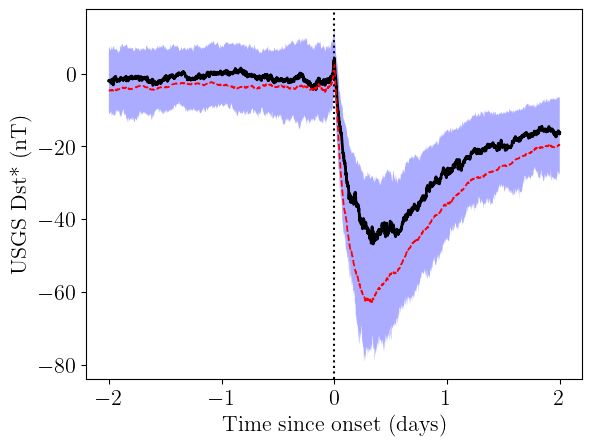

In [ ]:
import spacepy.seapy

onsets = spacepy.toolbox.loadpickle(os.path.join(tutorial_data, 'savesets', 'storm_onsets.pkl'))
# TRY: change the delta and window
superposed = spacepy.seapy.Sea(dst_star, dst_times, onsets,
                               delta=datetime.timedelta(minutes=1),
                               window=datetime.timedelta(days=2))
superposed.sea()
superposed.plot(xquan='Time since onset (days)', yquan='USGS Dst* (nT)',
                transparent=False, color='#ABABFF', epochline=True)

### Substorm onsets
One characteristic of a substorm onset is a dipolarization in the tail, where the "stretched" field lines move Earthward. This results in both betatron acceleration and second-order Fermi acceleration. The dipolarization can be observed by a change in the elevation angle of the magnetic field observed at GOES. This was, again, done in IDL before the previous study, and the data saved in IDL.

The data are stored as a time and the time since last substorm, from which a zero indicates currently in a dipolarization event. So first we extract all the times within an event, and then find only those times which start an event.

In [ ]:
substorm_data = scipy.io.readsav(os.path.join(tutorial_data, 'savesets', 'substorms.idl'))
# Get all times that are in dipolarization
substorm_times = numpy.array([
    datetime.datetime(substorm_data['goes_yyyy'][i], substorm_data['goes_mm'][i], substorm_data['goes_dd'][i])
    + datetime.timedelta(minutes=int(substorm_data['goes_min'][i]))
    for i in range(len(substorm_data['goes_yyyy']))
    if not substorm_data['last_substorm'][i]
])
# Convert to seconds since 1996-1-1
substorm_times = to_seconds(substorm_times)
# ith element is True if times[i+1] - times[i] > 60
idx = numpy.diff(substorm_times) > 60
# Also keep first one (obviously nothing before)
idx = numpy.concatenate(([True], idx))
print(numpy.sum(idx))  # number of dipolarizations
substorm_times = substorm_times[idx]

4265


## Association Analysis
We now have four lists of times: times when Polar was in the cusp, when Polar observed CEPs, dipolarization onsets, and storm onsets. We wish to know if there are any associations between these events which may imply causality, e.g., are energetic particles more likely to be observed after substorm onsets? This technique is described in detail in [Niehof and Morley, 2012](https://doi.org/10.2172/1035497) and implemented in the [PoPPy module](https://spacepy.github.io/poppy.html).

Consider two different series of events, each event occurring at a particular time. This might be, for instance, CEP observations and dipolarization onsets. Call these series A and series B, consisting of individual events e.g. a<sub>0</sub>, a<sub>1</sub>; b<sub>0</sub> etc. We could ask how many events in series B occur *at the same time* as events in series A. More reasonably, we might expect events that are most-or-less simultaneous to occur within a certain half-window, *h*, of each other. So in the example figure below, two events in series B occur within the half-window of a<sub>0</sub>, and we say the 0th association for series A is 2. Summing over all associations for a series gives the *association number*. Note that, after this summing, the result is symmetric. A higher association number indicates series that are more strongly associated.

![Example of association between two processes](https://raw.githubusercontent.com/heliophysicsPy/summer-school-24/refs/heads/main/spacepy-tutorial/series_example.svg)

We further want to identify associations between events that occur with some separation in time (e.g. perhaps events in series A regularly occur a short time before those in series B, but potentially outside the half-window *h*, so this sort of analysis is repeated with all the times for one series offset by a lag *u* relative to the other series. In the example, the lag shown has decreased the association; in general, the association number is a function of lag.

The question can be framed as this: for each of a set of times (lags), how many CEP observations happen within a given window of that time away from a dipolarization onset?

Depending on its energy, an ion would take approximately 15-120 minutes to gradient-curvature drift from the tail to the dayside. We thus choose 30 minutes as the window half-size for association.

Error: No confidence intervals to plot - skipping


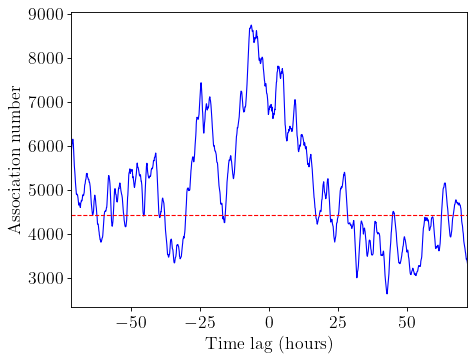

In [ ]:
import spacepy.poppy

# Calculate for +/-3 days at 5min resolution, doing everything in seconds
lags = list(range(-3 * 60 * 60 * 24, 3 * 60 * 60 * 24 + 1, 5 * 60))
pop = spacepy.poppy.PPro(substorm_times, cep_times, lags=lags, winhalf=30 * 60.)
pop.assoc()
# xscale: convert the seconds in the data to hours on the axis
pop.plot(norm=False, xlabel='Time lag (hours)', ylabel='Association number', xscale=3600.)

At very large lags, the expectation is that any association would be broken. The association number in this "asymptotic" region gives an indication of the level of chance association. Any greater than this number suggests a positive association. But it's obvious that there's a lot of variability even in the asymptotic region. The question is which of these are significant.

Confidence intervals on the association number can be calculated using the bootstrap, which repeatedly resamples the series of individual associations (with replacement) to estimate population statistics from the sample. This can be very computationally expensive, as it essentially involves repeating the association analysis thousands of times. This is performe

#### Things to try
Use a very small number of surrogates (e.g., 10). Use a different CI range (e.g., 60%)d in C and multithreaded for speed. For this tutorial, we use a smaller number of resamplings for speed, which may slightly reduce the accuracy of the confidence interval.

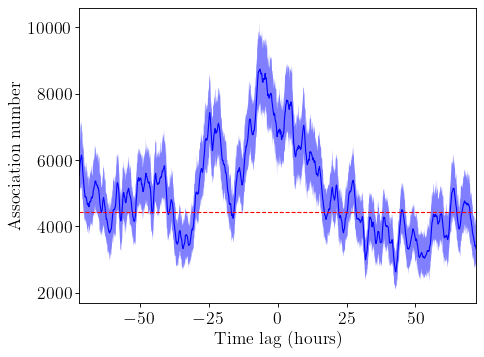

In [ ]:
# Build 95% confidence interval with 100 surrogates
# TRY: change confidence interval from 95, n_boots to more/fewer surrogates
pop.aa_ci(95, n_boots=100)
pop.plot(norm=False, xlabel='Time lag (hours)', ylabel='Association number', xscale=3600.)

This looks like a significant association of CEPs with substorm onsets, with the CEPs potentially slightly leading. But the association here is with energetic particles *observed in the cusp*, and it wouldn't be surprising to have geomagnetic reconfigurations affecting the likelihood of Polar observing the cusp. So let's check that possibility.

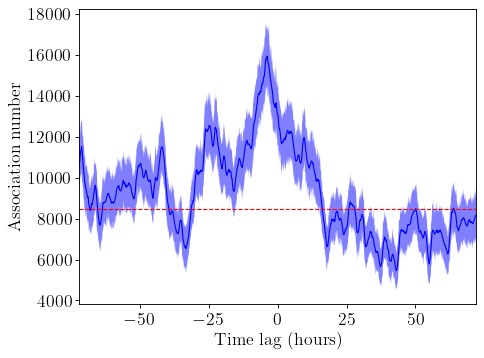

In [ ]:
pop_cusp = spacepy.poppy.PPro(substorm_times, cusp_times, lags=lags, winhalf=30 * 60.)
pop_cusp.assoc()
pop_cusp.aa_ci(95, n_boots=100)
pop_cusp.plot(norm=False, xlabel='Time lag (hours)', ylabel='Association number', xscale=3600.)

There are definitely some similarities. So the point of interest is whether energetic particles are *more* associated with dipolarizations than the cusp. That is the purpose of the [plot_two_ppro](https://spacepy.github.io/autosummary/spacepy.poppy.plot_two_ppro.html#spacepy.poppy.plot_two_ppro) function, which will plot two `PPro` objects normalized to one of them, to look for non-overlapping confidence intervals.

#### Things to try
Plot without normalization, to see the separate cusp and CEP associations.

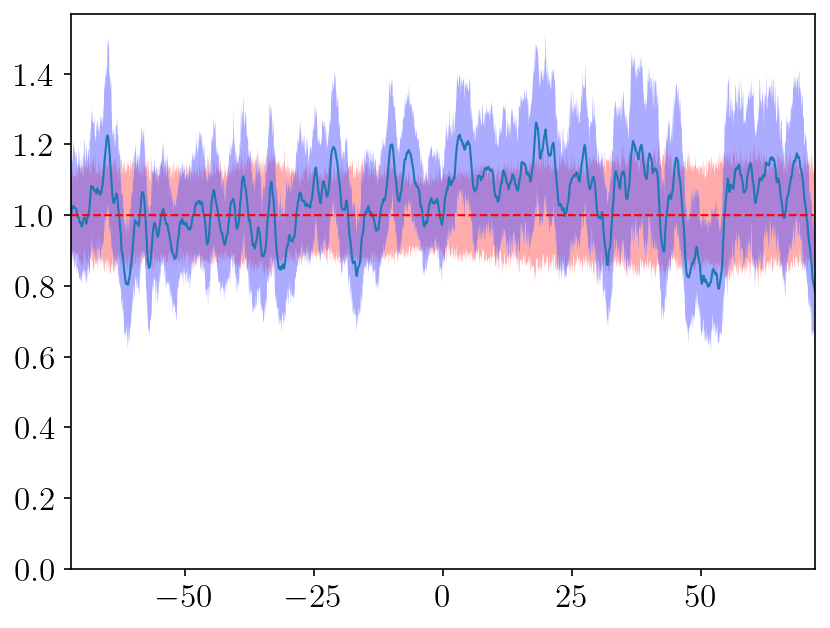

In [ ]:
# TRY: also use norm=False to see separate associations
spacepy.poppy.plot_two_ppro(pop, pop_cusp, norm=True, xscale=3600, dpi=150)

Barely visible is the slight increase in association (about 96% confidence) around lags of 3-3.5 hours, i.e., with the CEP observations occurring about 3 hours after the dipolarization. This is supportive of the hypothesis that cusp energetic particles are accelerated in substorms and drift to the dayside. There is no significant association with CEPs *leading* the dipolarizations.

We can perform a similar analysis for storm onsets.

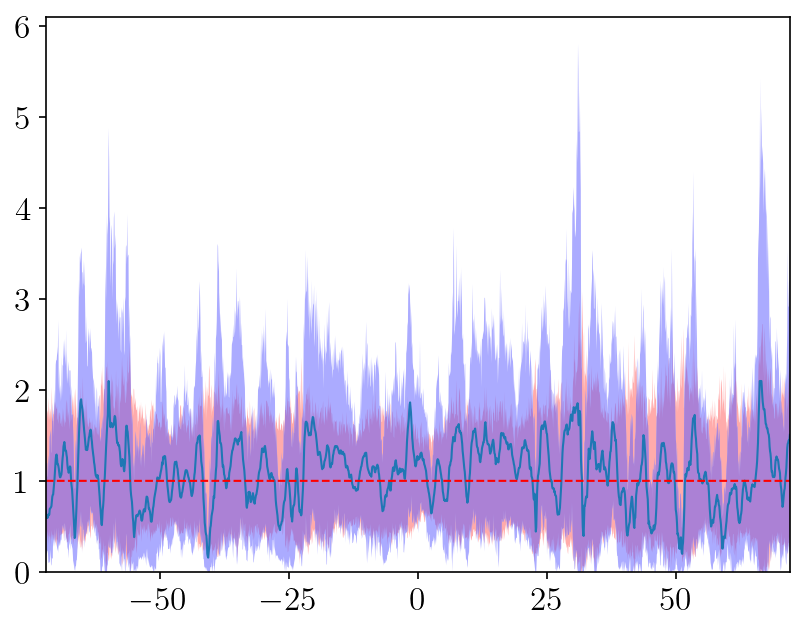

In [ ]:
storm_times = to_seconds(onsets)
pop = spacepy.poppy.PPro(storm_times, cep_times, lags=lags, winhalf=30 * 60.)
pop.assoc()
pop.aa_ci(95, n_boots=100)
pop_cusp = spacepy.poppy.PPro(storm_times, cusp_times, lags=lags, winhalf=30 * 60.)
pop_cusp.assoc()
pop_cusp.aa_ci(95, n_boots=100)
spacepy.poppy.plot_two_ppro(pop, pop_cusp, norm=True, xscale=3600, dpi=150)

This shows pretty clearly that there is no association between CEP observations and geomagnetic storm onsets, suggesting that CEPs cannot be a major and direct driver of the ring current.

#### Things to try
Examine the association between storm onsets and substorm onsets.

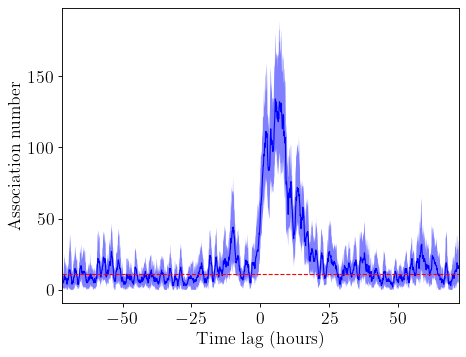

In [ ]:
pop = spacepy.poppy.PPro(storm_times, substorm_times, lags=lags, winhalf=30 * 60.)
pop.assoc()
pop.aa_ci(95, n_boots=100)
pop.plot(norm=False, xlabel='Time lag (hours)', ylabel='Association number', xscale=3600.)